<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Andrea Flores Fernández y Tania Bell Nicholls.

**Fecha:** 09 de octubre del 2021.

**Expediente** : IF725449 y IF716767.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Tania-Bell/Proyecto_TBell_AFlores.git

# Proyecto Simulación - Censo de Ingresos

## Descripción

> Nuestro dataset contiene las mediciones de 4 meses con diferentes variables que nos ayudan a predecir el nivel de radiación solar. Predecir la radiación solar es importante ya que es la fuente de energía mas importante de la tierra y tiene efectos balance de radiación en la superficie, ciclos hidrológicos, fotosíntesis, condiciones meteorológicas y climas extremos.  



## Objetivos

> #### Objetivo General:
Obtener la probabilidad de una alta radiación solar 

> #### Objetivo específico:
    > - 
    > - 
    > - 
    > - 

## Definición del Problema



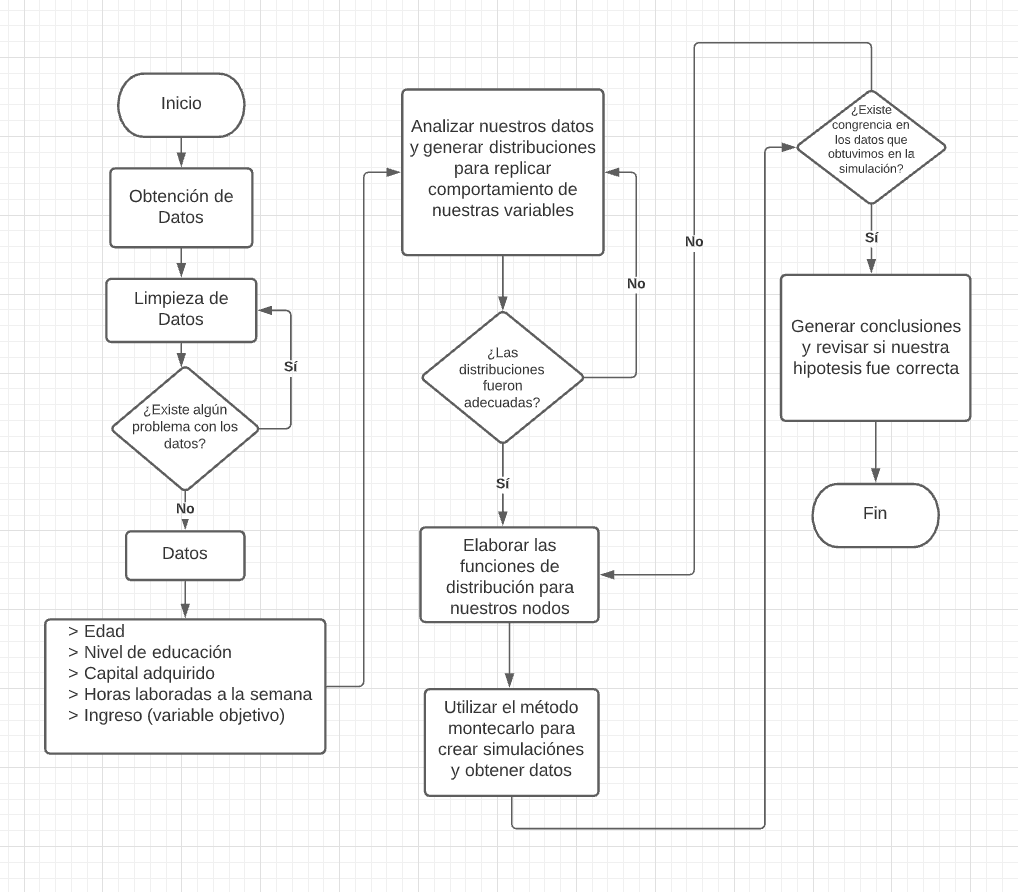

## Nodos y variables que se decidieron simular y por qué

>Para desarrollar el proyecto tomamos las siguientes variables:
    > - Temperatura: 
    > - Presión: 
    > - Humedad:
    > - Velocidad:


## Definición de hipótesis y supuestos



## Librerías y Funciones

In [1]:
# importación de las librerías
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.api as sm 
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from sklearn.model_selection import GridSearchCV
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import warnings
warnings.filterwarnings("ignore")

In [2]:
def histograma(dataset:'Dataset',
               datos:'Nodo',
               title:'Titulo de grafica',
               bin:'Numero de bins'):
    '''
    Funcion que genera el histograma de datos proporcionados y numero de bins dados
    '''
    plt.figure(figsize=(7,4))
    plt.hist(dataset[datos], bins = bin, density=True);
    plt.title(title);

def boxplot(data:'Nodo',
           title:'Titulo de grafica'):
    '''
    Funcion que genera el boxplot de datos proporcionados
    '''
    plt.boxplot(data,vert=False)
    plt.title(title)
    plt.show()

def kde_statsmodels_m(x, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          #bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return lambda x_grid: kde.pdf(x_grid)


def distribuciones(data:'Nodo'):
    '''
    Iteración con las diferentes distribuciones. Retorna el plot con las distribuciones y tabla de error
    '''
    #generación de iteración de distribuciones en st, sólo las continuas
    rv_continuas = [d_i for d_i in dir(st) if isinstance(getattr(st, d_i), getattr(st, 'rv_continuous'))]

    #fig, ax = plt.subplots(1, 1, figsize=(10,7))
    #crea la tabla de errores por ditribución iterada
    error = pd.DataFrame(columns=['Distribución', 'Error'])
    i = 0
    y, x, _ = plt.hist(data, bins=50, density=True)
    x = x[1:]
    #se ejecuta la iteración
    for d_i in rv_continuas[20:30] + ['beta']:
        try:
            params = getattr(st, d_i).fit(data)
            data_hat = getattr(st, d_i).pdf(x, *params) # usando probability distribution function
            #ax.plot(x, data_hat, label=d_i)
            error.loc[i, :] = [d_i, np.mean((y - data_hat)**2)]
            i += 1
        except ValueError:
            pass

    #plt.legend()
    error.set_index('Distribución', inplace=True)
    error.sort_values('Error', inplace=True)
    return error

def pruebaq_q(data:'Nodo', 
              dist:'Distribución óptima'):
    '''
    Prueba Q_Q, genera gráfica con la distribución y la gráfica Q_Q (45 grados)
    '''
    # Histograma de las variables creadas
    fig, ax = plt.subplots(2,1, figsize=(8,10))
    fig.tight_layout(pad=3.0)
    # distribuciones y prueba
    y, x, _ = ax[0].hist(data, 50, density=True, label='Histograma')
    params = getattr(st, dist).fit(data)
    y_hat = getattr(st, dist).pdf(x, *params) # usando probability distribution function
    # creación de gráficas
    ax[0].plot(x, y_hat,'r--', label='Distribución ajustada')
    ax[0].set_ylabel('Probabilidad')
    ax[0].grid()
    grafica = st.probplot(data, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
    ax[1].grid()
    ax[1].set_title(dist)
    plt.show()
    
def red_var(data:'Nodo', N:'Número para muestra',f:'Pdf', t:'Función lambda', model:'Model'):
    '''
    Reducción de Varianza y Montecarlo, retorna las variables aceptadas
    '''
    # parámetros y generación de variables
    r1 = muestra_est(N) # usando función del muestreo estratificado
    np.random.shuffle(r1)
    ct = 0
    i = 0
    var_acept = np.zeros(1000)
    # iteración de aceptación o rechazo
    while ct < 1000:    
        r = np.random.uniform(min(data), max(data), 1)
        f_x = f(r, model)
        t_x = t(r)
        condition = r1[i] * t_x <= f_x
        if condition[0]:
            var_acept[ct] = r[0]
            ct += 1
        i+=1
    return var_acept

def pdf(x:'x_grid, intervalo', model:'Model'):
    '''
    Pdf para reducción de varianza
    '''
    return np.exp(model.score_samples(x.reshape(-1, 1)))

def muestra_est(n:'Número de muestras'):
    '''
    Muestreo Estratificado
    '''
    # generación de variables aleatorias entre 0 y 1
    u = np.random.uniform(0, 1, n)
    i = np.arange(0, n)
    return (u + i) / n

def kolmogorov(data:'Nodo',dist:'Distribución Óptima'):
    '''
    Prueba Kolmogorov-Smirnov
    '''
    param = getattr(st, dist).fit(data)
    return st.kstest(data, dist, args = (param))

def chi_cuadrada(dist:'Distribución Óptima', data:'Nodo', x:'x', y:'y', J1:'Bins', c:'Confianza'):
    '''
    Prueba de Chi cuadrada, genera el teórico, el de la librería, el estadístico y arroja media y desviación estándar
    '''
    # parámetros
    param = getattr(st, dist).fit(data)
    pi = getattr(st, dist).pdf(x, *param) # usando probability distribution function
    
    Ei = x*pi

    x2 = np.sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, y))) # teórico
    print('Chi cuadrado teórico: ', x2)

    X2 = st.chisquare(y, Ei) # usando librería scipy.stats
    print('Chi cuadrado stats: ', X2)

    p = len(param) 
    m = J1-p-1 
    
    Chi_est = st.chi2.ppf(q=c, df=m) # estadístico
    print('Estadístico de chi_cuadrado: ', Chi_est)
    
    mu = np.mean(x) # media
    sigma = np.std(x) # desviación estándar
    print('Media muestral = ', mu, '\nDesviación estándar muestral = ', sigma)

## Obtención de bases de datos

> Nuestro dataset fue proporcionado por la NASA y lo obtuvimos de una publicación en Kaggle 

> https://www.kaggle.com/dronio/SolarEnergy/version/1

In [3]:
# importación de los datos, el archivo está en un csv y se llama adult
data = pd.read_csv('SolarPrediction.csv')
#data = data[['age','educational-num','capital-gain','hours-per-week']].head(20001)
data

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


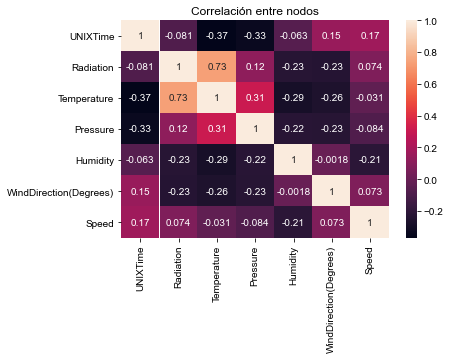

In [4]:
# análisis de correlación entre los datos
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True, linewidths=.0001)
sn.set(rc = {'figure.figsize':(5,5)})
plt.title('Correlación entre nodos') # generación de tabla
plt.show()

interpretación: 

## Visualización de Variables

Para generar una idea general de nuestros datos, los visualizaremos usando histogramas. Nos mostrará, a primera vista, si hay una distribución obvia en nuestros nodos.

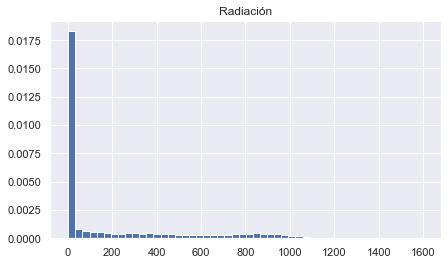

In [5]:
# histograma para visualizar objetivo: la Radiación 
histograma(data,'Radiation','Radiación',50)

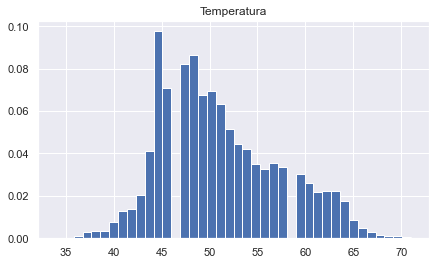

In [6]:
# histograma para visualizar la variable temperatura
histograma(data,'Temperature','Temperatura',40)

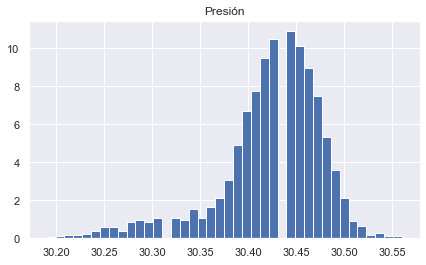

In [7]:
# histograma con 40 bins para visualizar la variable presión 
histograma(data,'Pressure','Presión',40)

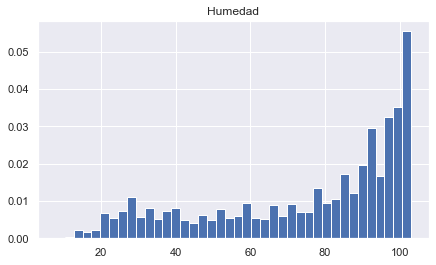

In [8]:
# histograma para visualizar la variable humedad 
histograma(data,'Humidity','Humedad',40)

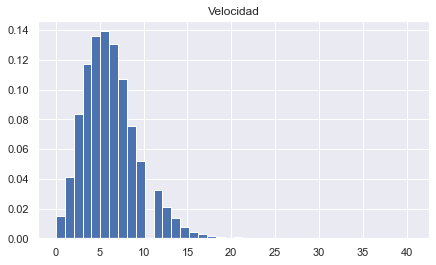

In [9]:
# histograma para visualizar la variable velocidad
histograma(data,'Speed','Velocidad',40)

## Procedimiento de la simulación:

>Primero, generaremos box-plots para visualizar los outliers y poderlos eliminar para tener datos más uniformes. Luego, implementaremos algunos métodos como logaritmo o raíz cuadrada para ajustar los datos. Como tercer paso, encontraremos el bandwidth adecuado para cada nodo y posteriormente realizaremos el método de KDE usando la librería Scikit-learn. Después realizaremos el método de reducción de varianza usando aceptación y rechazo. Luego simularemos con varias distribuciones para ver cuál es la más adecuada para cada nodo. Usando la distribución con menor error, realizaremos la prueba Q_Q, kolmogorov y chi cuadrada. 

## Nodo 1: Temperatura 

#### Box-Plots y Ajuste de datos

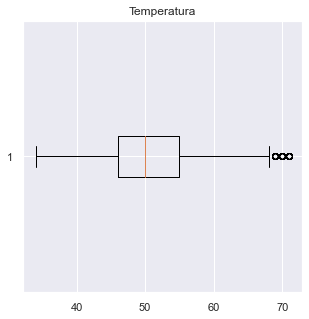

In [10]:
temp = np.array(data['Temperature'])
boxplot(temp,'Temperatura') #mostramos boxplot e identificamos outliers 

#### KDE

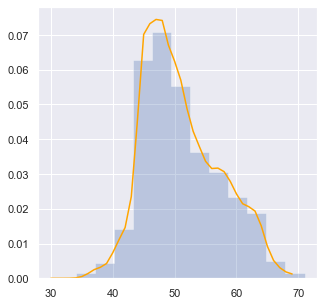

In [11]:
x_grid = np.arange(30,70)
kde = kde_statsmodels_m(temp)
plt.plot(x_grid, kde(x_grid),c='orange')
plt.hist(temp, bins=12, fc='b', histtype='stepfilled', alpha=0.3, density=True)
plt.show()

#### Reducción de Varianza

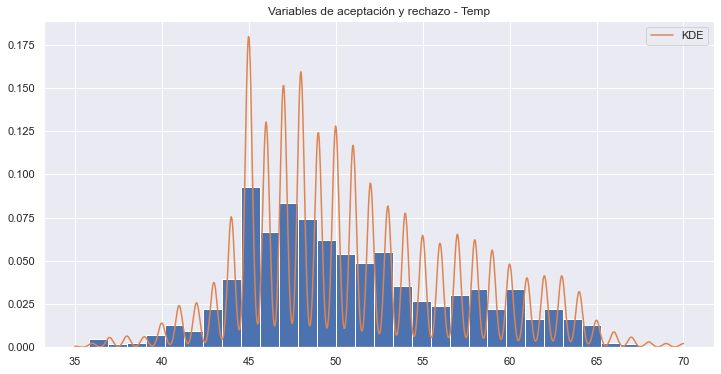

In [12]:
model = KernelDensity(bandwidth=0.2) #usando bandwidth óptimo
model.fit(temp.reshape(-1, 1))
x_grid = np.linspace(35, 70, 1000)
pdf_temp = pdf(x_grid[:, None], model) # usando función pdf

plt.figure(figsize=(12,6))
var_aleatorias = red_var(temp,100000,pdf, lambda x: max(pdf_temp) * np.ones(len(x)), model) # usand pdf
plt.hist(var_aleatorias, 30, density=True)

plt.plot(x_grid, pdf_temp, alpha=1, label='KDE') # graficamos
plt.title('Variables de aceptación y rechazo - Temp')
plt.legend()
plt.show()

#### Distribuciones

,Error
Distribución,
fisk,0.000579159
fatiguelife,0.000580119
exponweib,0.000580335
gamma,0.000584014
beta,0.000585325
f,0.000606735
frechet_r,0.000636604
gausshyper,0.000642338
foldnorm,0.00065797


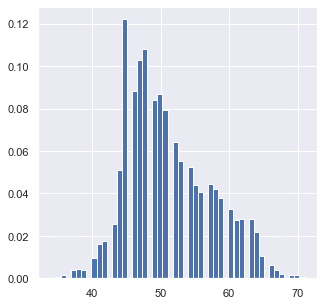

In [13]:
distribuciones(temp) # la mejor distribución fue fisk para el nodo temperatura 

#### Prueba Q_Q

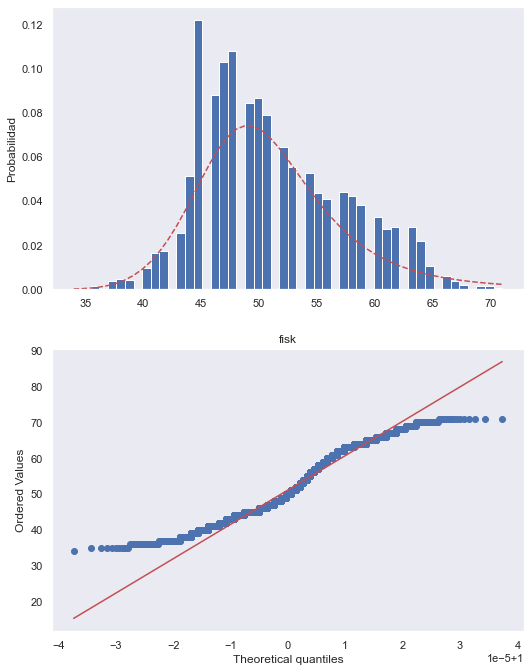

In [14]:
pruebaq_q(temp,'fisk') # llama la función para hacer la prueba de 45 grados 

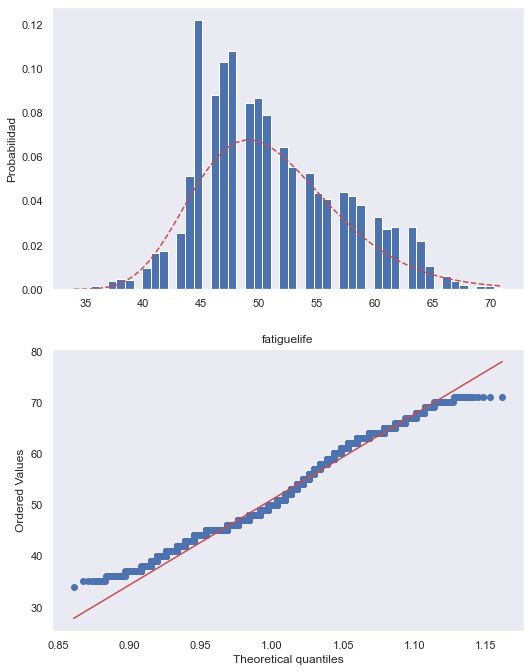

In [15]:
pruebaq_q(temp,'fatiguelife') # llama la función para hacer la prueba de 45 grados 

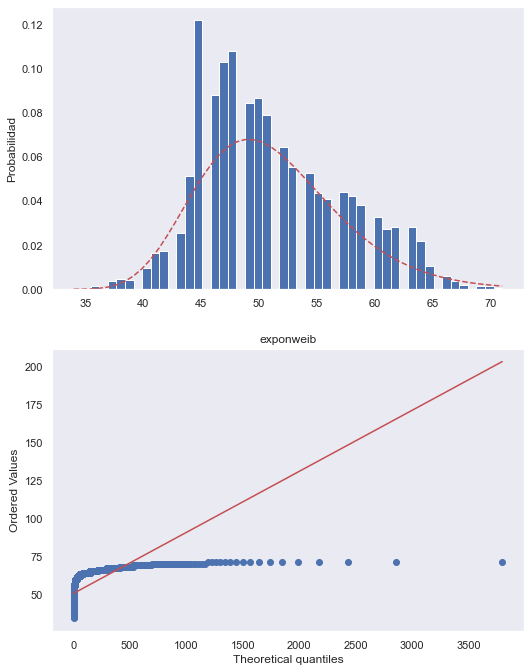

In [16]:
pruebaq_q(temp,'exponweib') # llama la función para hacer la prueba de 45 grados 

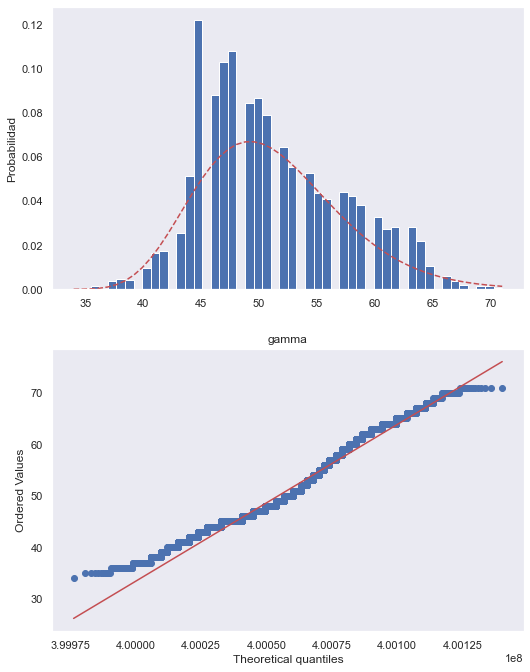

In [17]:
pruebaq_q(temp,'gamma') # llama la función para hacer la prueba de 45 grados 

#### Prueba Kolmogorov-Smirnov

In [18]:
kolmogorov(temp,'fisk') # hacemos prueba de kolmogrov 

KstestResult(statistic=0.07267499101612213, pvalue=1.427658237335528e-150)

In [19]:
kolmogorov(temp,'fatiguelife') # hacemos prueba de kolmogrov 

KstestResult(statistic=0.07422492837844252, pvalue=4.726000019039795e-157)

In [20]:
kolmogorov(temp,'gamma') # hacemos prueba de kolmogrov 

KstestResult(statistic=0.07572264732191525, pvalue=1.914851128060736e-163)

#### Prueba Chi Cuadrada

Chi cuadrado teórico:  39.57119394186237
Chi cuadrado stats:  Power_divergenceResult(statistic=39.57119394186237, pvalue=0.09119599749838148)
Estadístico de chi_cuadrado:  38.885138659830055
Media muestral =  53.11666666666666 
Desviación estándar muestral =  10.675044453025668


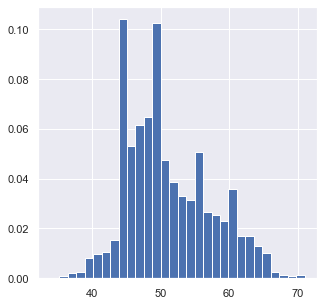

In [21]:
J1 = 30
y, x, _ = plt.hist(temp, bins = J1, density = True)
x = x[1:]
chi_cuadrada('fatiguelife',temp,x,y,J1,0.95) # aplicamos la prueba de chi cuadrada 

## Nodo 2: Presión

#### Box-Plots y Ajuste de datos

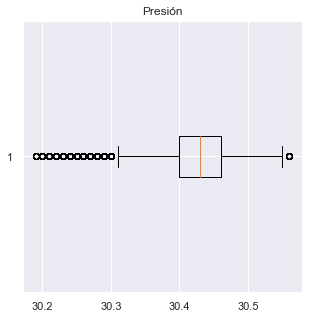

In [22]:
pres = np.array(data['Pressure'])
boxplot(pres,'Presión') # sacamos boxplot para ver la distribución de nuestros datos

In [23]:
# normalizamos datos con standars score ya que con logaritmo y sqrt no tuvimos los resultados que queríamos
pres_std = pres.std()
pres_mean = pres.mean()
pres = (pres-pres_mean)/pres_std
pres = pres[~np.isnan(pres)]
pres # aplicamos una transformación de raiz cuadrada para mejorar la distribución de nuestros datos

array([ 0.67897416,  0.67897416,  0.67897416, ..., -0.05265751,
       -0.05265751,  0.1302504 ])

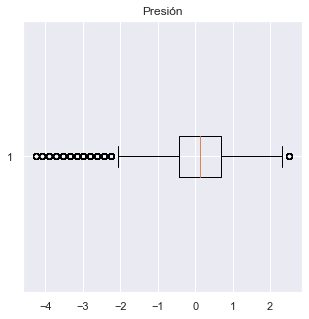

In [24]:
boxplot(pres,'Presión') # usamos showfliers para eliminar los outliers ya que la transformación no fue suficiente 

#### KDE

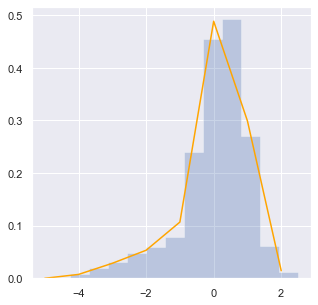

In [25]:
x_grid = np.arange(-5,3)
kde = kde_statsmodels_m(pres)
plt.plot(x_grid, kde(x_grid),c='orange')
plt.hist(pres, bins=12, fc='b', histtype='stepfilled', alpha=0.3, density=True)
plt.show()

#### Reducción de Varianza y Montecarlo

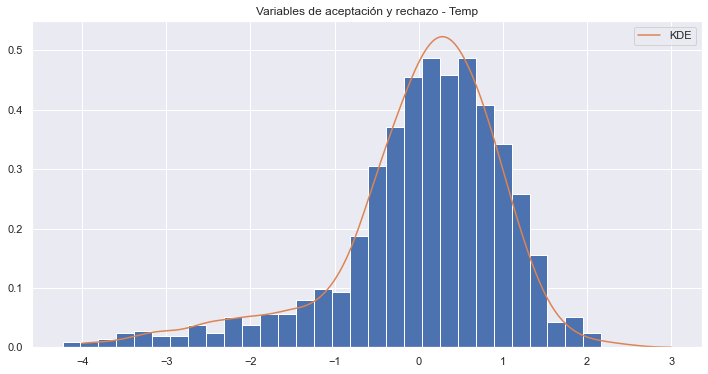

In [26]:
model = KernelDensity(bandwidth=0.2) #usando bandwidth óptimo
model.fit(pres.reshape(-1, 1))
x_grid = np.linspace(-4, 3, 1000)
pdf_pres = pdf(x_grid[:, None], model) # usando función pdf

plt.figure(figsize=(12,6))
var_aleatorias = red_var(pres,100000,pdf, lambda x: max(pdf_pres) * np.ones(len(x)), model) # usand pdf

plt.hist(var_aleatorias, 30, density=True)

plt.plot(x_grid, pdf_pres, alpha=1, label='KDE') # graficamos
plt.title('Variables de aceptación y rechazo - Temp')
plt.legend()
plt.show()

#### Distribuciones

,Error
Distribución,
exponweib,0.0195129
foldcauchy,0.0207333
beta,0.0211432
fisk,0.0214189
frechet_l,0.0245244
foldnorm,0.0250134
fatiguelife,0.025115
gamma,0.0265658
gausshyper,0.0341759


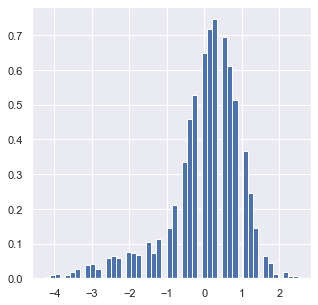

In [27]:
distribuciones(pres)

#### Prueba Q_Q

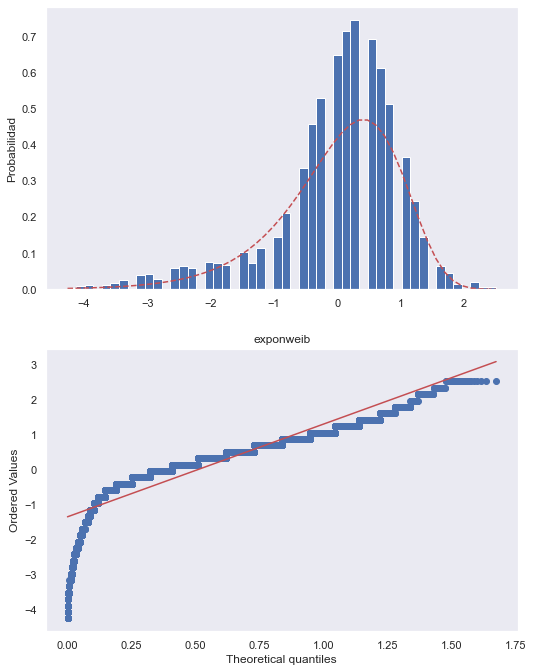

In [28]:
pruebaq_q(pres,'exponweib') # probamos las mejores distribuciones con la prueba q_q

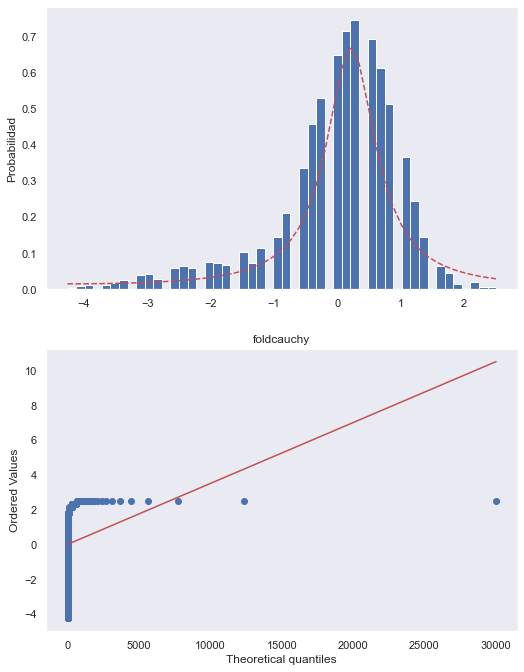

In [29]:
pruebaq_q(pres,'foldcauchy') # probamos las mejores distribuciones con la prueba q_q

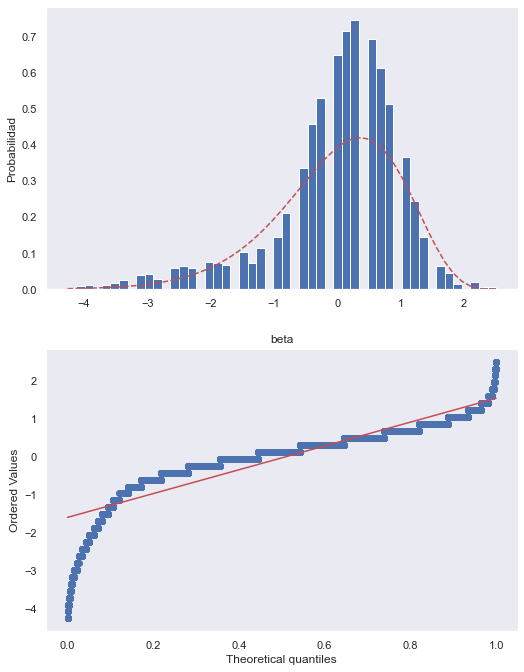

In [30]:
pruebaq_q(pres,'beta') # probamos las mejores distribuciones con la prueba q_q

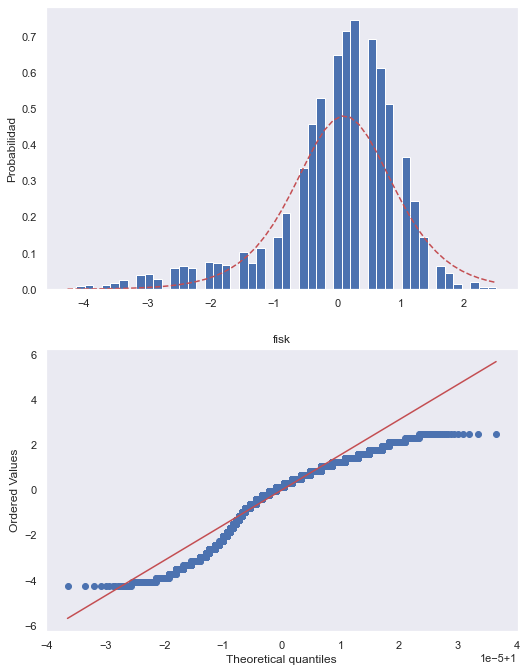

In [31]:
pruebaq_q(pres,'fisk') # probamos las mejores distribuciones con la prueba q_q

#### Prueba Kolmogorov-Smirnov

In [32]:
kolmogorov(pres,'exponweib') # prueba de kolmogrov 

KstestResult(statistic=0.06942032140862103, pvalue=2.065441850000042e-137)

In [33]:
kolmogorov(pres,'beta') # prueba de kolmogrov 

KstestResult(statistic=0.09418408139721213, pvalue=8.5682234774786e-253)

In [34]:
kolmogorov(pres,'f') # prueba de kolmogrov 

KstestResult(statistic=0.42895383062245357, pvalue=0.0)

#### Prueba Chi Cuadrada

Chi cuadrado teórico:  168.51560883773325
Chi cuadrado stats:  Power_divergenceResult(statistic=168.51560883773325, pvalue=1.3009883964439752e-21)
Estadístico de chi_cuadrado:  37.65248413348277
Media muestral =  -0.7629499299139515 
Desviación estándar muestral =  1.9525501576031037


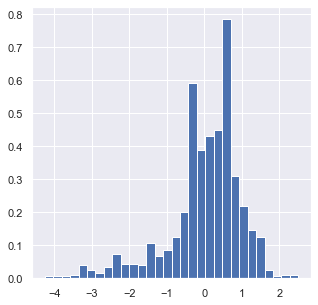

In [35]:
J1 = 30
y, x, _ = plt.hist(pres, bins = J1, density = True)
x = x[1:]
chi_cuadrada('f',pres,x,y,J1,0.95) # prueba de chicuadrada 

## Nodo 3: Humedad 

#### Box-Plots y Ajuste de datos

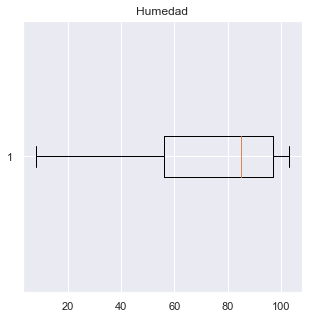

In [36]:
hume = np.array(data['Humidity'])
boxplot(hume,'Humedad') # mostramos boxplot de datos para ver si hay muchos outliers

#### KDE

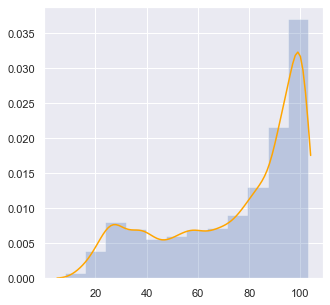

In [37]:
x_grid = np.arange(5,105)
kde = kde_statsmodels_m(hume)
plt.plot(x_grid, kde(x_grid),c='orange')
plt.hist(hume, bins=12, fc='b', histtype='stepfilled', alpha=0.3, density=True)
plt.show()

#### Distribuciones

,Error
Distribución,
foldcauchy,8.38996e-05
exponweib,9.44032e-05
fisk,0.000108003
f,0.000111269
fatiguelife,0.000112453
gamma,0.00011442
foldnorm,0.000197029
frechet_r,0.000311335
gausshyper,5.85187e+09


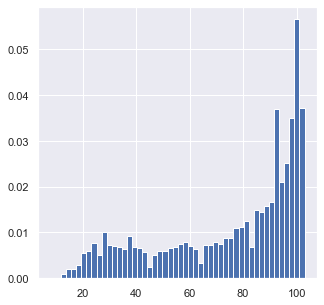

In [38]:
distribuciones(hume)

#### Prueba Q_Q

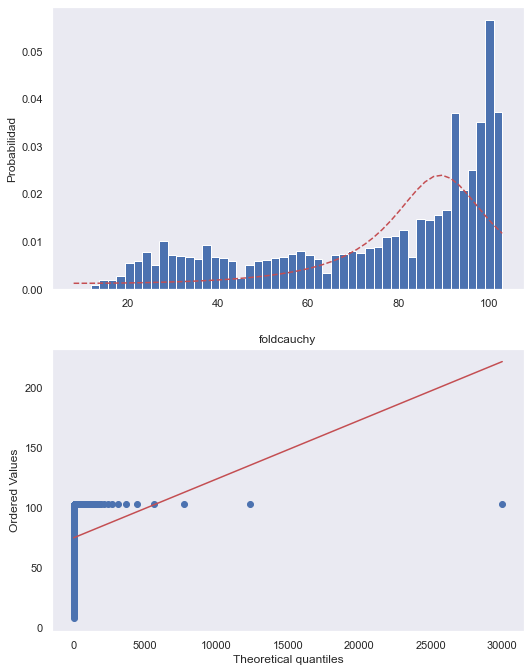

In [39]:
pruebaq_q(hume,'foldcauchy')

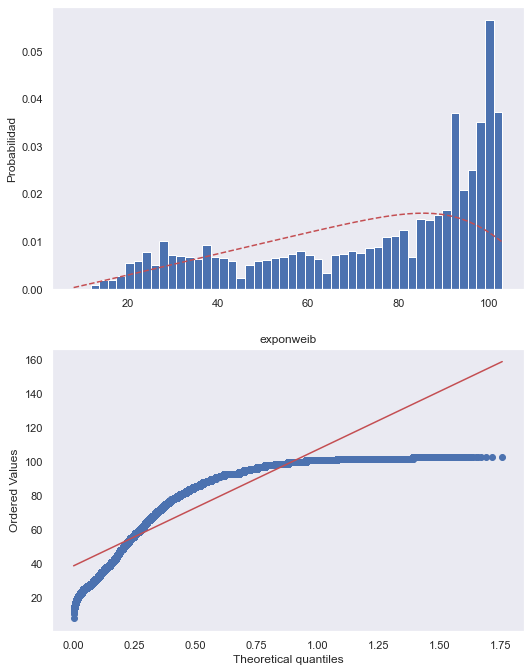

In [40]:
pruebaq_q(hume,'exponweib')

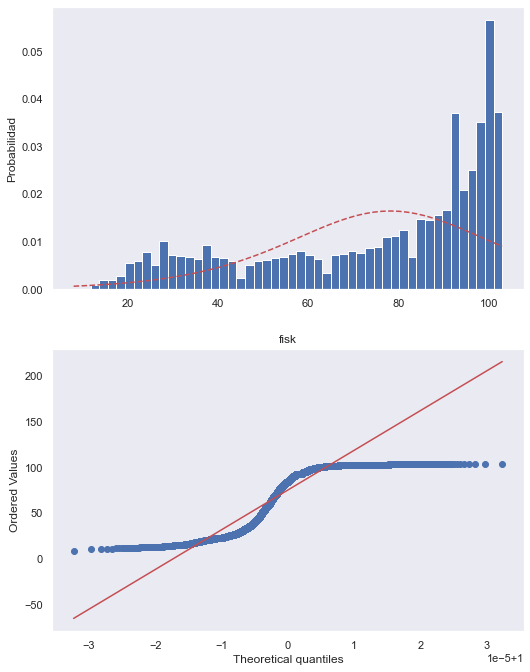

In [41]:
pruebaq_q(hume,'fisk')

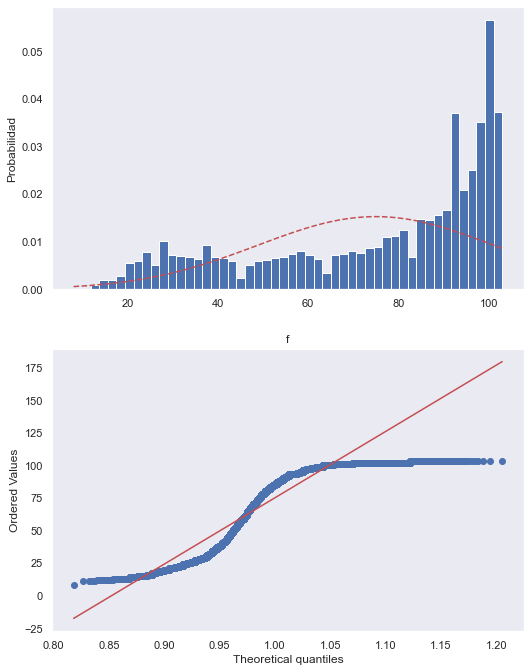

In [42]:
pruebaq_q(hume,'f')

#### Prueba Kolmogorov-Smirnov

In [43]:
kolmogorov(hume,'exponweib') # prueba de kolmogrov 

KstestResult(statistic=0.18979415242849074, pvalue=0.0)

In [44]:
kolmogorov(hume,'fisk') # prueba de kolmogrov 

KstestResult(statistic=0.16688009812313076, pvalue=0.0)

In [45]:
kolmogorov(hume,'f') # prueba de kolmogrov 

KstestResult(statistic=0.15486908188528026, pvalue=0.0)

#### Prueba Chi Cuadradra

Chi cuadrado teórico:  18.275174049293877
Chi cuadrado stats:  Power_divergenceResult(statistic=18.275174049293877, pvalue=0.9384710557836308)
Estadístico de chi_cuadrado:  37.65248413348277
Media muestral =  57.083333333333336 
Desviación estándar muestral =  27.408897919930766


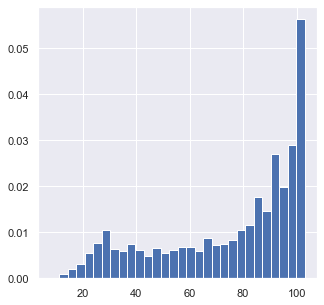

In [46]:
J1 = 30
y, x, _ = plt.hist(hume, bins = J1, density = True)
x = x[1:]
chi_cuadrada('f',hume,x,y,J1,0.95) # prueba de chicuadrada 

## Nodo 4: Velocidad

#### Box-plots y Ajuste de Datos

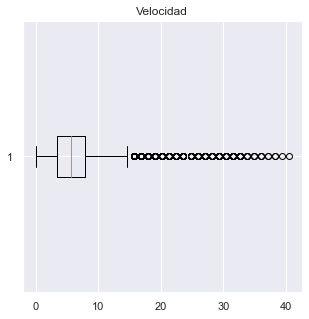

In [47]:
velo = np.array(data['Speed'])
boxplot(velo,'Velocidad')

#### KDE

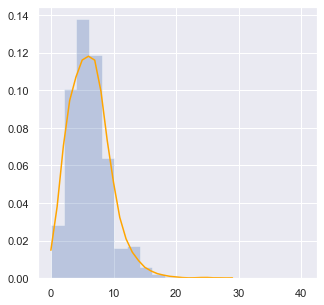

In [48]:
x_grid = np.arange(0,30)
kde = kde_statsmodels_m(velo)
plt.plot(x_grid, kde(x_grid),c='orange')
plt.hist(velo, bins=20, fc='b', histtype='stepfilled', alpha=0.3, density=True)
plt.show()

#### Distribuciones

,Error
Distribución,
fisk,0.000872727
fatiguelife,0.000887489
beta,0.000888494
gamma,0.000889451
frechet_r,0.000920204
foldnorm,0.000942371
gausshyper,0.00179657
foldcauchy,0.00212359
f,0.00284497


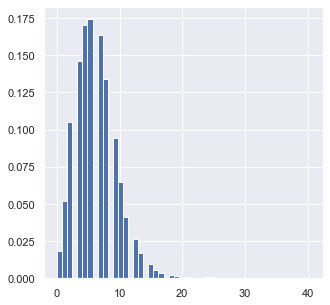

In [49]:
distribuciones(velo)

#### Prueba Q_Q

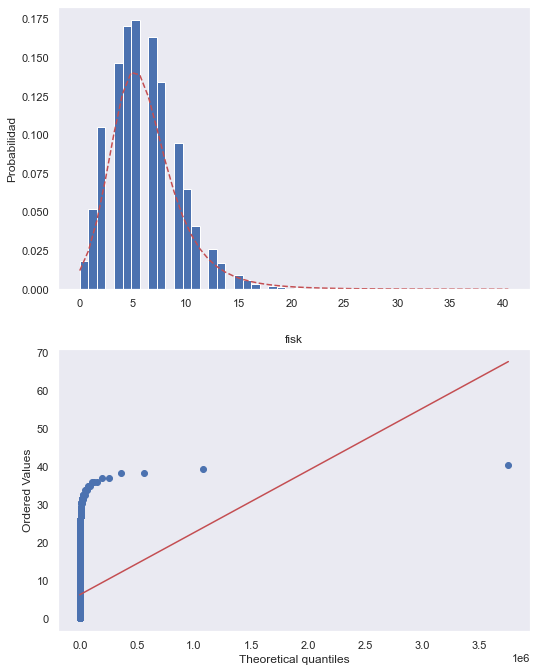

In [50]:
pruebaq_q(velo,'fisk')

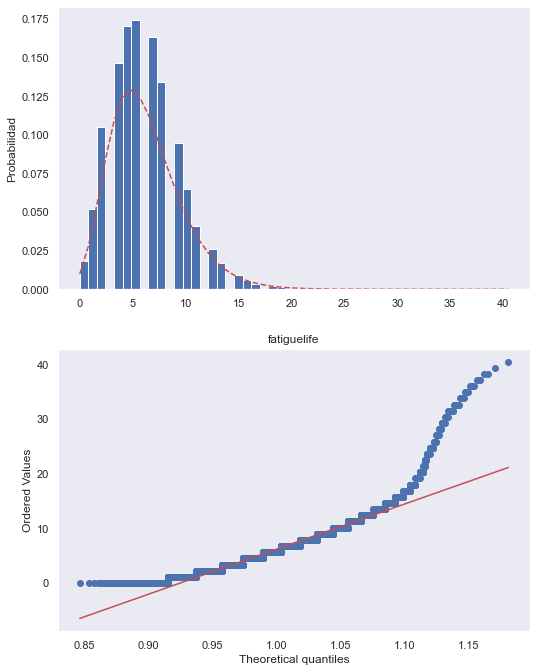

In [51]:
pruebaq_q(velo,'fatiguelife')

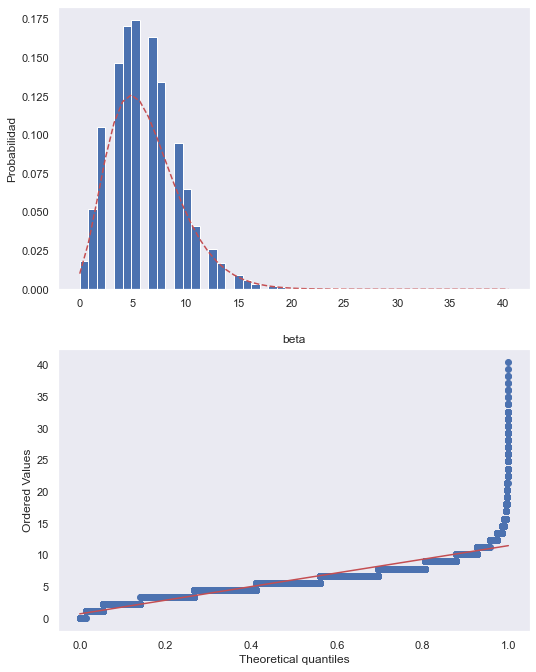

In [52]:
pruebaq_q(velo,'beta')

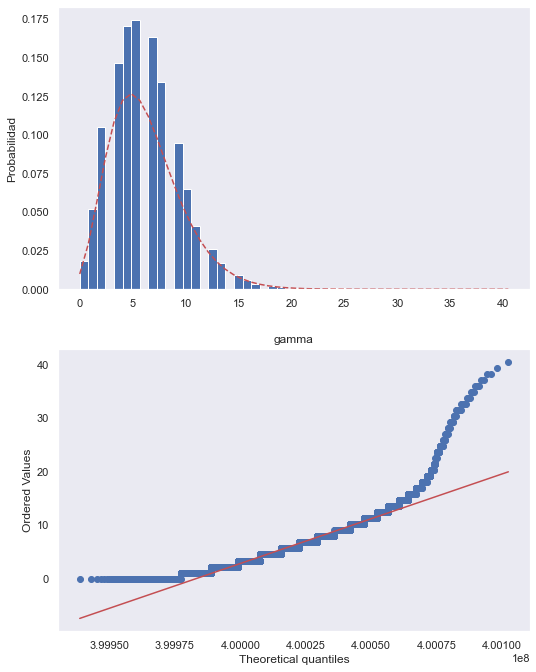

In [53]:
pruebaq_q(velo,'gamma')

#### Prueba Kolmogorov-Smirnov

In [54]:
kolmogorov(velo,'fatiguelife') # prueba de kolmogrov 

KstestResult(statistic=0.08384299469403761, pvalue=2.4462908852503942e-200)

In [55]:
kolmogorov(velo,'beta') # prueba de kolmogrov 

KstestResult(statistic=0.08116566802952946, pvalue=9.329704642733676e-188)

In [56]:
kolmogorov(velo,'gamma') # prueba de kolmogrov 

KstestResult(statistic=0.08271439012502163, pvalue=5.522727441454002e-195)

#### Prueba Chi Cuadrada

Chi cuadrado teórico:  -74102295097057.2
Chi cuadrado stats:  Power_divergenceResult(statistic=-74102295097057.2, pvalue=1.0)
Estadístico de chi_cuadrado:  38.885138659830055
Media muestral =  -0.7629499299139515 
Desviación estándar muestral =  1.9525501576031037


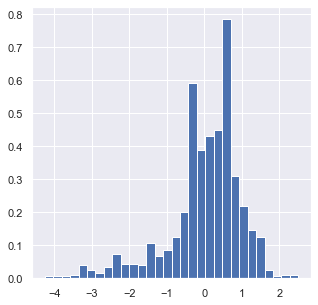

In [57]:
J1 = 30
y, x, _ = plt.hist(pres, bins = J1, density = True)
x = x[1:]
chi_cuadrada('fatiguelife',velo,x,y,J1,0.95) # prueba de chicuadrada 

### Visualización de resultados de simulación

### Conclusiones

## Conclusiones primeros 2 Nodos

En ambos casos nos damos cuenta que con nuestros datos ajustados podemos encontrar distribuciones que pueden representar correctamente nuestros datos, lo que nos da cierta confianza de que tenemos buenas aproximaciones. Para llegar a esto fue necesario encontrar una transformación adecuada para nuestros datos y en el segundo caso eliminar los outliers que todavia se mostraban en el boxplot. Después encontramos el bandwith adecuado para nuestro KDE, para despues usar el método de varianza y despues montecarlo modelando nuestros datos. Con esto buscamos una distribución adecuada para nuestros datos y usamos la que mejor se ajustara para realizar diferentes pruebas de nuestras distribución (Chi cuadrada, kolmogrov,) con los gráficos y los datos arrojados nos damos cuenta que aun pueden exisistir mejores distribuciones pero las que tenemos muestran buenos resultados 


### Referencias

T.T.B. (2021, 4 agosto). Medical Insurance Premium Prediction. Recuperado 9 de octubre de 2021, de https://www.kaggle.com/tejashvi14/medical-insurance-premium-prediction